# Import Libraries

In [3]:
import numpy as np
import cv2
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, ClassifierMixin
# Import different classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [120]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

# Interface Declarations

## Data Loading Logic

In [4]:
class FruitQualityDataLoader:
    def __init__(self):
        self.quality_mappings = {
            'fresh': 0, 'good': 0,
            'mild': 1,
            'rotten': 2, 'bad': 2
        }
        self.quality_labels = ['Good/Fresh', 'Mild/Mixed', 'Rotten/Bad']
        
    def load_zenodo_dataset(self, base_path, subset="FruQ-DB"):
        """Load Zenodo dataset"""
        base_path = Path(base_path)
        image_paths = []
        labels = []
        
        if subset == "FruQ-DB":
            dataset_path = base_path / "FruQ-DB"
            if not dataset_path.exists():
                raise ValueError(f"FruQ-DB not found at {dataset_path}")
            
            # Process quality folders directly
            quality_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
            
            for folder in quality_folders:
                if folder.name.lower() in self.quality_mappings:
                    label = self.quality_mappings[folder.name.lower()]
                    print(f"Processing {folder.name}...")
                    
                    for img_path in folder.glob('*.[jp][pn][g]'):
                        image_paths.append(str(img_path))
                        labels.append(label)
        
        elif subset == "FruQ-multi":
            dataset_path = base_path / "FruQ-multi"
            fruit_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
            
            for fruit_folder in fruit_folders:
                print(f"Processing fruit: {fruit_folder.name}")
                quality_folders = [f for f in fruit_folder.iterdir() if f.is_dir()]
                
                for folder in quality_folders:
                    if folder.name.lower() in self.quality_mappings:
                        label = self.quality_mappings[folder.name.lower()]
                        print(f"Processing quality: {folder.name}...")
                        
                        for img_path in folder.glob('*.[jp][pn][g]'):
                            image_paths.append(str(img_path))
                            labels.append(label)
                            
        return self._summarize_and_return(image_paths, labels)

    def load_kaggle_dataset(self, base_path):
        """
        Load Kaggle dataset with the following structure:
        - Bad Quality_Fruits/
            - Apple_Bad/
            - Banana_Bad/
            etc.
        - Good Quality_Fruits/
            - Apple_Good/
            - Banana_Good/
            etc.
        - Mixed Quality_Fruits/
            - Apple/
            - Banana/
            etc.
        """
        base_path = Path(base_path)
        image_paths = []
        labels = []
        
        # Define quality directories and their corresponding labels
        quality_dirs = {
            'Bad Quality_Fruits': 2,    # maps to 'bad'/'rotten'
            'Good Quality_Fruits': 0,   # maps to 'good'/'fresh'
               # maps to 'mixed'/'mild'
        }
        
        # Process each quality directory
        for quality_dir, label in quality_dirs.items():
            quality_path = base_path / quality_dir
            if not quality_path.exists():
                print(f"Warning: {quality_dir} not found at {quality_path}")
                continue
                
            print(f"\nProcessing {quality_dir}...")
            
            # Get all fruit subdirectories
            fruit_dirs = [f for f in quality_path.iterdir() if f.is_dir()]
            
            # Process each fruit directory
            for fruit_dir in fruit_dirs:
                print(f"Processing {fruit_dir.name}...")
                
                # Handle both .jpg and .png files
                for img_path in fruit_dir.glob('*.[jp][pn][g]'):
                    image_paths.append(str(img_path))
                    labels.append(label)
        
        return self._summarize_and_return(image_paths, labels)
    
    def _summarize_and_return(self, image_paths, labels):
        """Helper method to summarize dataset statistics and return results"""
        print(f"\nDataset Statistics:")
        unique, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return image_paths, np.array(labels)
    
    def load_combined_datasets(self, kaggle_path, zenodo_path, zenodo_subset="FruQ-DB"):
        """
        Load and combine both Kaggle and Zenodo datasets
        """
        # Load Kaggle dataset
        kaggle_paths, kaggle_labels = self.load_kaggle_dataset(kaggle_path)
        
        # Load Zenodo dataset
        zenodo_paths, zenodo_labels = self.load_zenodo_dataset(zenodo_path, zenodo_subset)
        
        # Combine datasets
        combined_paths = kaggle_paths + zenodo_paths
        combined_labels = np.concatenate([kaggle_labels, zenodo_labels])
        
        print("\nCombined Dataset Statistics:")
        unique, counts = np.unique(combined_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return combined_paths, combined_labels
    
    def load_banana_data(self, kaggle_path, zenodo_path):
        """
        Load only banana data from both Kaggle and Zenodo datasets, including both FruQ-DB and FruQ-multi/BananaDB
        Returns:
            tuple: (kaggle_data, zenodo_data) where each is a tuple of (image_paths, labels)
        """
        zenodo_banana_paths = []
        zenodo_banana_labels = []
        
        # Load only from FruQ-multi/BananaDB
        banana_db_path = Path(zenodo_path) / "FruQ-multi" / "BananaDB"
        if banana_db_path.exists():
            print("Processing BananaDB from FruQ-multi...")
            for quality_dir in banana_db_path.iterdir():
                if quality_dir.is_dir() and quality_dir.name.lower() in self.quality_mappings:
                    label = self.quality_mappings[quality_dir.name.lower()]
                    print(f"Processing {quality_dir.name}...")
                    for img_path in quality_dir.glob('*.[jp][pn][g]'):
                        zenodo_banana_paths.append(str(img_path))
                        zenodo_banana_labels.append(label)

        # Load Kaggle banana data
        base_path = Path(kaggle_path)
        kaggle_banana_paths = []
        kaggle_banana_labels = []
        
        # Process each quality directory for bananas
        quality_dirs = {
            'Bad Quality_Fruits': ('Banana_Bad', 2),    # maps to 'bad'/'rotten'
            'Good Quality_Fruits': ('Banana_Good', 0),   # maps to 'good'/'fresh'
            'Mixed Qualit_Fruits': ('Banana', 1)    # maps to 'mixed'/'mild'
        }
        
        for quality_dir, (banana_dir, label) in quality_dirs.items():
            dir_path = base_path / quality_dir / banana_dir
            if not dir_path.exists():
                print(f"Warning: {dir_path} not found")
                continue
                
            print(f"Processing {quality_dir}/{banana_dir}...")
            # Handle both .jpg and .png files
            for img_path in dir_path.glob('*.[jp][pn][g]'):
                kaggle_banana_paths.append(str(img_path))
                kaggle_banana_labels.append(label)
        
        kaggle_banana_labels = np.array(kaggle_banana_labels)
        
        # Print statistics for both datasets
        print("\nZenodo Banana Dataset Statistics:")
        unique, counts = np.unique(zenodo_banana_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        print("\nKaggle Banana Dataset Statistics:")
        unique, counts = np.unique(kaggle_banana_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        # Convert labels to numpy arrays
        kaggle_banana_labels = np.array(kaggle_banana_labels)
        zenodo_banana_labels = np.array(zenodo_banana_labels)
        
        # Print detailed statistics
        print("\nZenodo Banana Dataset Statistics:")
        print(f"Total images: {len(zenodo_banana_paths)}")
        unique, counts = np.unique(zenodo_banana_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        print("\nKaggle Banana Dataset Statistics:")
        print(f"Total images: {len(kaggle_banana_paths)}")
        unique, counts = np.unique(kaggle_banana_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return {
            'kaggle': {
                'paths': kaggle_banana_paths,
                'labels': kaggle_banana_labels
            },
            'zenodo': {
                'paths': zenodo_banana_paths,
                'labels': zenodo_banana_labels
            }
        }

## Feature Extractor Logic

In [5]:
class FruitFeatureExtractor:
    def __init__(self, target_size=(224, 224), hist_bins=32, method='statistical'):
        """
        Initialize the feature extractor
        Args:
            target_size (tuple): Target size for image resizing
            hist_bins (int): Number of bins for histogram features
            method (str): Feature extraction method ('statistical', 'histogram', or 'both')
        """
        self.target_size = target_size
        self.hist_bins = hist_bins
        self.method = method
        self.scaler = StandardScaler()
    
    def compute_pca(self,histograms, n_components=5):
        """
        Apply PCA to reduce the dimensionality of histogram vectors.

        Args:
            histograms (list): List of histogram vectors.
            n_components (int): Number of dimensions for PCA.

        Returns:
            pca_result (np.ndarray): PCA-transformed data with specified components.
        """
        pca = PCA(n_components=n_components)
        print("i got called")
        pca_result = pca.fit_transform(histograms)
        return pca_result
            
    def compute_histogram(self, img, color_space="RGB"):
        """
        Compute histograms for the three channels of the image in a specified color space.
        Args:
            img (numpy.ndarray): Input image.
            color_space (str): The color space to use ('RGB', 'HSV', or 'HLS').
        Returns:
            histograms (numpy.ndarray): Flattened array of histograms for each channel.
        """
        if img is None:
            print("Error: Image is None")
            return np.zeros(self.hist_bins * 3)
            
        # Convert the image to the specified color space
        if color_space == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == "HLS":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            
        histograms = []
        for channel in [0, 1, 2]:
            hist = cv2.calcHist([img], [channel], None, [self.hist_bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            histograms.extend(hist)
        
        #PCA
        
        return np.array(histograms)
    
    def extract_statistical_features(self, img):
        """Extract statistical features from image in multiple color spaces"""
        features = []
        
        # Convert to different color spaces
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        # Extract features from each color space
        for color_img in [img, hsv_img, lab_img]:
            for channel in cv2.split(color_img):
                features.extend([
                    np.mean(channel),
                    np.std(channel),
                    np.percentile(channel, 25),
                    np.percentile(channel, 75)
                ])
                
        return np.array(features)
    
    def extract_histogram_features(self, img):
        """Extract histogram features from image in multiple color spaces"""
        features = []
        
        # BGR (original format from cv2.imread)
        features.extend(self.compute_histogram(img, "RGB"))
        
        # HSV
        # hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # features.extend(self.compute_histogram(hsv_img, "HSV"))
        
        # # HLS
        # hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        # features.extend(self.compute_histogram(hls_img, "HLS"))
        
        return np.array(features)
    
    def extract_features(self, img_path):
        """Extract features based on specified method"""
        # Read and resize image
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            return np.zeros(self.get_feature_size())
            
        img = cv2.resize(img, self.target_size)
        
        if self.method == 'statistical':
            return self.extract_statistical_features(img)
        elif self.method == 'histogram':
            return self.extract_histogram_features(img)
        elif self.method == 'both':
            stat_features = self.extract_statistical_features(img)
            hist_features = self.extract_histogram_features(img)
            return np.concatenate([stat_features, hist_features])
        else:
            raise ValueError(f"Unknown method: {self.method}")
    
    def get_feature_size(self):
        """Get the size of the feature vector based on method"""
        stat_size = 36  # 4 statistics × 3 channels × 3 color spaces
        hist_size = self.hist_bins * 9  # bins × 3 channels × 3 color spaces
        
        if self.method == 'statistical':
            return stat_size
        elif self.method == 'histogram':
            return hist_size
        elif self.method == 'both':
            return stat_size + hist_size
        else:
            raise ValueError(f"Unknown method: {self.method}")
    
    def prepare_dataset(self, image_paths, fit_scaler=True):
        """Extract features from all images and scale them"""
        features = []
        total_images = len(image_paths)
        
        for i, img_path in enumerate(image_paths):
            if i % 100 == 0 or i == total_images - 1:
                print(f"Processing image {i+1}/{total_images}", end='\r')
            features.append(self.extract_features(img_path))
        
        features = np.array(features)
        
        if fit_scaler:
            features = self.scaler.fit_transform(features)
        else:
            features = self.scaler.transform(features)
            
        print("\nFeature extraction completed!")
        print(f"Feature vector size: {features.shape[1]} ({self.method} features)")
        return features

    def get_feature_names(self):
        """Return list of feature names based on method"""
        feature_names = []
        
        if self.method in ['statistical', 'both']:
            # Statistical features
            color_spaces = ['BGR', 'HSV', 'LAB']
            stats = ['mean', 'std', 'p25', 'p75']
            channels = ['1', '2', '3']
            
            for cs in color_spaces:
                for ch in channels:
                    for stat in stats:
                        feature_names.append(f"{cs}_{ch}_{stat}")
        
        if self.method in ['histogram', 'both']:
            # Histogram features
            hist_color_spaces = ['RGB', 'HSV', 'HLS']
            for cs in hist_color_spaces:
                for ch in range(3):
                    for bin_idx in range(self.hist_bins):
                        feature_names.append(f"{cs}_ch{ch+1}_hist_bin{bin_idx+1}")
        
        return feature_names

In [123]:
def compute_histogram(image_data, color_space="RGB", bins=32):
    """
    Compute histograms for the three channels of the image in a specified color space.

    Args:
        image_data (ImageData): Object containing image details.
        color_space (str): The color space to use ('RGB', 'HSV', or 'HLS').
        bins (int): Number of bins for the histogram.

    Returns:
        histograms (list): List of histograms for each channel in the specified color space.
    """
    histograms = []
    print(image_data)

    if image_data and image_data.matrix is not None:
        # Convert the image to the specified color space
        if color_space == "HSV":
            img = cv2.cvtColor(image_data.matrix, cv2.COLOR_RGB2HSV)
        elif color_space == "HLS":
            img = cv2.cvtColor(image_data.matrix, cv2.COLOR_RGB2HLS)
        else:  # Default to RGB
            img = image_data.matrix

        # Compute histograms for the three channels
        for channel in [0, 1, 2]:  # Three channels for RGB/HSV/HLS
            hist = cv2.calcHist([img], [channel], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            histograms.append(hist)
    else:
        print("Error: ImageData is invalid or image matrix is None.")
    
    return histograms


def display_histogram(histograms, title="Histogram - RGB"):
    """
    Display histograms for the RGB channels.

    Args:
        histograms (list): List of histograms for each channel.
        title (str): Title of the histogram plot.
    """
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(8, 4))
    for hist, color in zip(histograms, colors):
        plt.plot(hist, color=color)
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("Frequency")
    plt.show()

def compute_pca(histograms, n_components=2):
    """
    Apply PCA to reduce the dimensionality of histogram vectors.

    Args:
        histograms (list): List of histogram vectors.
        n_components (int): Number of dimensions for PCA.

    Returns:
        pca_result (np.ndarray): PCA-transformed data with specified components.
    """
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(histograms)
    return pca_result

def display_pca(pca_results, states):
    """
    Display the PCA results as a scatter plot.

    Args:
        pca_results (np.ndarray): PCA-transformed histogram vectors.
        states (list): List of states corresponding to the PCA results.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(pca_results[:, 0], pca_results[:, 1], c=['green', 'orange', 'red'], s=100)
    for i, state in enumerate(states):
        plt.text(pca_results[i, 0], pca_results[i, 1], state, fontsize=12, ha='center', va='center')
    plt.title("PCA of Histograms - RGB Channels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid()
    plt.show()

## Model Evaluator Logic

In [124]:
class ModelEvaluator:
    def __init__(self, quality_labels=['Fresh', 'Mild', 'Rotten']):
        self.quality_labels = quality_labels
    
    def evaluate_model(self, y_true, y_pred, model_name="Model"):
        """Evaluate model performance with metrics and visualization"""
        print(f"\n{model_name} Performance:")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.quality_labels))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.quality_labels,
                   yticklabels=self.quality_labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Test Classification with Baseline Models

In [125]:
# Cell 2: Baseline Classifiers
class RandomClassifier(BaseEstimator, ClassifierMixin):
    """Classifier that predicts randomly based on training class distribution"""
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.class_probs_ = np.bincount(y) / len(y)
        return self
        
    def predict(self, X):
        return np.random.choice(self.classes_, size=len(X), p=self.class_probs_)

class MajorityClassifier(BaseEstimator, ClassifierMixin):
    """Classifier that always predicts the most common class from training"""
    def fit(self, X, y):
        self.majority_class_ = np.bincount(y).argmax()
        return self
        
    def predict(self, X):
        return np.full(len(X), self.majority_class_)

In [178]:
extractor_hist = FruitFeatureExtractor(method='histogram')
def extract_basic_features(img_path):
    """Extract only mean RGB values as features"""
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (224, 224))
    # features_hist = extractor_hist.extract_histogram_features(img)
    # return features_hist
    mean_rgb = np.mean(img, axis=(0,1))  # Just mean of each channel
    return mean_rgb

In [127]:
def run_baseline_tests(train_paths, train_labels, test_paths, test_labels):
    # 1. Try random classifier
    print("\nRandom Classifier (based on class distribution):")
    rand_clf = RandomClassifier()
    rand_clf.fit(None, train_labels)
    rand_pred = rand_clf.predict(test_labels)
    print(classification_report(test_labels, rand_pred))
    
    # 2. Try majority classifier
    print("\nMajority Classifier:")
    maj_clf = MajorityClassifier()
    maj_clf.fit(None, train_labels)
    maj_pred = maj_clf.predict(test_labels)
    print(classification_report(test_labels, maj_pred))

In [128]:
def get_random_subset_with_labels(paths, labels, percent):
    """
    Returns a random subset of both paths and labels maintaining their correspondence.
    
    Parameters:
    - paths: List of image paths
    - labels: Array of corresponding labels
    - percent: The percentage of data to retrieve (0-100)
    
    Returns:
    - tuple: (subset_paths, subset_labels)
    """
    if not (0 <= percent <= 100):
        raise ValueError("Percent must be between 0 and 100.")
    
    if len(paths) != len(labels):
        raise ValueError(f"Number of paths ({len(paths)}) does not match number of labels ({len(labels)})")
    
    # Calculate the number of samples
    sample_size = int(len(paths) * (percent / 100))
    
    # Create indices for the full dataset
    indices = list(range(len(paths)))
    
    # Randomly sample indices
    selected_indices = random.sample(indices, sample_size)
    
    # Use the same indices to select both paths and labels
    subset_paths = [paths[i] for i in selected_indices]
    subset_labels = labels[selected_indices]
    
    print(f"Created subset with {len(subset_paths)} samples "
          f"({percent}% of {len(paths)} original samples)")
    
    # Print distribution of labels in original and subset
    unique_orig, counts_orig = np.unique(labels, return_counts=True)
    unique_sub, counts_sub = np.unique(subset_labels, return_counts=True)
    
    print("\nLabel distribution:")
    print("Original | Subset")
    print("---------|---------")
    for label, count_orig, count_sub in zip(unique_orig, counts_orig, counts_sub):
        orig_percent = count_orig / len(labels) * 100
        sub_percent = count_sub / len(subset_labels) * 100
        print(f"Label {label}: {count_orig} ({orig_percent:.1f}%) | {count_sub} ({sub_percent:.1f}%)")
    
    return subset_paths, subset_labels

In [177]:
loader = FruitQualityDataLoader()

# Split data
#from sklearn.model_selection import train_test_split
# train_paths, test_paths, train_labels, test_labels = train_test_split(
#     image_paths, labels, test_size=0.2, random_state=42, stratify=labels
# )


train_paths, train_labels = loader.load_zenodo_dataset('fruit_datasets/zenodo_data', subset="FruQ-DB")
test_paths, test_labels = loader.load_kaggle_dataset("fruit_datasets/kaggle_data")
train_paths_subset, train_labels_subset = get_random_subset_with_labels(
    train_paths, 
    train_labels, 
    percent=50  # for example, get 10% of the data
)

test_paths_subset, test_labels_subset = get_random_subset_with_labels(
    test_paths,
    test_labels,
    percent=50
)


print(len(train_paths), "train_paths")
print(len(test_paths), "test_paths")

print(len(test_paths_subset), "test_paths subset")
print(len(train_paths_subset), "train_paths subset")

# data = loader.load_banana_data(
#     kaggle_path='fruit_datasets/kaggle_data',
#     zenodo_path='fruit_datasets/zenodo_data'
# )
# Run baseline tests
run_baseline_tests(train_paths, train_labels, test_paths, test_labels)

Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images

Processing Bad Quality_Fruits...
Processing Apple_Bad...
Processing Banana_Bad...
Processing Guava_Bad...
Processing Lime_Bad...
Processing Orange_Bad...
Processing Pomegranate_Bad...

Processing Good Quality_Fruits...
Processing Apple_Good...
Processing Banana_Good...
Processing Guava_Good...
Processing Lime_Good...
Processing Orange_Good...
Processing Pomegranate_Good...

Dataset Statistics:
Good/Fresh: 9170 images
Rotten/Bad: 5575 images
Created subset with 2823 samples (50% of 5647 original samples)

Label distribution:
Original | Subset
---------|---------
Label 0: 2182 (38.6%) | 1059 (37.5%)
Label 1: 1364 (24.2%) | 706 (25.0%)
Label 2: 2101 (37.2%) | 1058 (37.5%)
Created subset with 7372 samples (50% of 14745 original samples)

Label distribution:
Original | Subset
---------|---------
Label 0: 9170 (62.2%) | 4571 (62.0%)
Label 2

/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/sit

## Check to see if there is data leakage

In [130]:
def check_path_overlap(train_paths, test_paths):
   train_set = set(train_paths)
   test_set = set(test_paths)
   
   overlap = train_set.intersection(test_set)
   
   if overlap:
       print(f"Found {len(overlap)} overlapping paths")
       print("Sample overlaps:")
       for path in list(overlap)[:5]:
           print(path)
       return True
   else:
       print("No overlapping paths found")
       return False

In [131]:
has_overlap = check_path_overlap(train_paths, test_paths)

No overlapping paths found


## KNN with reduced feature set

In [179]:
print("\nKNN with basic RGB means only:")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Extract basic features
print("Extracting basic features...")
train_features = np.array([extract_basic_features(path) for path in train_paths])
test_features = np.array([extract_basic_features(path) for path in test_paths])
print(train_features)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Train and evaluate
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features_scaled, train_labels)
basic_pred = knn.predict(test_features_scaled)
print(classification_report(test_labels, basic_pred))


KNN with basic RGB means only:
Extracting basic features...
[[ 54.17484455  92.28908243 202.16852679]
 [139.8622449  176.71669723 215.16691247]
 [ 54.17484455  92.28908243 202.16852679]
 ...
 [203.05420918 204.51847497 207.99055325]
 [202.97540657 204.45681202 208.04904735]
 [202.99661193 204.48901865 207.92466518]]
              precision    recall  f1-score   support

           0       0.88      0.32      0.47      9170
           1       0.00      0.00      0.00         0
           2       0.52      0.91      0.66      5575

    accuracy                           0.54     14745
   macro avg       0.47      0.41      0.38     14745
weighted avg       0.74      0.54      0.54     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# KNN with 32 bins histogram data

In [168]:
class HistogramPCATransformer:
    def __init__(self, n_components=5):
        """
        Initialize PCA transformer for histogram features
        Args:
            n_components (int): Number of PCA components to keep
        """
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        
    def fit_transform_train(self, features):
        """
        Fit PCA on training data and transform it
        Args:
            features (np.ndarray): Training features of shape (n_samples, n_features)
        Returns:
            np.ndarray: Transformed features of shape (n_samples, n_components)
        """
        print(f"Fitting PCA on training data of shape: {features.shape}")
        transformed_features = self.pca.fit_transform(features)
        
        # Print explained variance information
        explained_variance_ratio = self.pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        print("\nExplained variance ratio by component:")
        for i, var in enumerate(explained_variance_ratio):
            print(f"Component {i+1}: {var:.4f} ({cumulative_variance_ratio[i]:.4f} cumulative)")
            
        return transformed_features
    
    def transform_test(self, features):
        """
        Transform test features using pre-fitted PCA
        Args:
            features (np.ndarray): Test features to transform of shape (n_samples, n_features)
        Returns:
            np.ndarray: Transformed features of shape (n_samples, n_components)
        """
        if not hasattr(self.pca, 'components_'):
            raise ValueError("PCA has not been fitted. Call fit_transform_train first.")
            
        print(f"Transforming test data of shape: {features.shape}")
        return self.pca.transform(features)

# Usage example:
def process_features_with_pca(train_features, test_features, n_components=5):
    """
    Process both training and test features with PCA
    Args:
        train_features (np.ndarray): Training features
        test_features (np.ndarray): Test features
        n_components (int): Number of PCA components
    Returns:
        tuple: (transformed_train_features, transformed_test_features)
    """
    # Initialize PCA transformer
    pca_transformer = HistogramPCATransformer(n_components=n_components)
    
    # Fit and transform training data
    print("\nProcessing training features...")
    train_features_pca = pca_transformer.fit_transform_train(train_features)
    
    # Transform test data
    print("\nProcessing test features...")
    test_features_pca = pca_transformer.transform_test(test_features)
    
    print("\nFinal shapes:")
    print(f"Training features: {train_features_pca.shape}")
    print(f"Test features: {test_features_pca.shape}")
    
    return train_features_pca, test_features_pca

In [173]:
# First extract your histogram features
train_features = np.array([extract_basic_features(path) for path in train_paths_subset])
test_features = np.array([extract_basic_features(path) for path in test_paths_subset])

# Then apply PCA
train_features_pca, test_features_pca = process_features_with_pca(
    train_features, 
    test_features, 
    n_components=10
)

# Use transformed features for classification
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_features_pca, train_labels_subset)
predictions = classifier.predict(test_features_pca)
print(classification_report(test_labels_subset, predictions))


Processing training features...
Fitting PCA on training data of shape: (2823, 96)

Explained variance ratio by component:
Component 1: 0.5418 (0.5418 cumulative)
Component 2: 0.2840 (0.8259 cumulative)
Component 3: 0.0503 (0.8762 cumulative)
Component 4: 0.0400 (0.9162 cumulative)
Component 5: 0.0211 (0.9373 cumulative)
Component 6: 0.0158 (0.9531 cumulative)
Component 7: 0.0118 (0.9649 cumulative)
Component 8: 0.0081 (0.9730 cumulative)
Component 9: 0.0046 (0.9776 cumulative)
Component 10: 0.0044 (0.9820 cumulative)

Processing test features...
Transforming test data of shape: (7909, 96)

Final shapes:
Training features: (2823, 10)
Test features: (7909, 10)
              precision    recall  f1-score   support

           0       0.60      0.84      0.70      4543
           1       0.26      0.25      0.25       549
           2       0.46      0.17      0.25      2817

    accuracy                           0.56      7909
   macro avg       0.44      0.42      0.40      7909
weight

# Test Classification with ML Models

In [13]:
# Initialize loader and extractor
loader = FruitQualityDataLoader()
extractor = FruitFeatureExtractor()

# Load dataset
image_paths, labels = loader.load_zenodo_dataset('fruit_datasets/zenodo_data', subset="FruQ-DB")

# Split data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Extract features
print("Extracting training features...")
X_train = extractor.prepare_dataset(train_paths, fit_scaler=True)
print("Extracting test features...")
X_test = extractor.prepare_dataset(test_paths, fit_scaler=False)

Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images
Extracting training features...
Processing image 4500/4517
Feature extraction completed!
Extracting test features...
Processing image 1100/1130
Feature extraction completed!


In [14]:
has_overlap = check_path_overlap(train_paths, test_paths)

No overlapping paths found


In [ ]:
# Initialize evaluator
evaluator = ModelEvaluator()

# Dictionary of classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50)),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, train_labels)
    
    print(f"Evaluating {name}...")
    predictions = clf.predict(X_test)
    evaluator.evaluate_model(test_labels, predictions, name)

# Test Regression Model

## Regressor Logic

In [6]:
class FruitQualityRegressor:
    def __init__(self, n_anchor_samples=3, target_size=(224, 224)):
        """
        Initialize the fruit quality regression system.
        
        Parameters:
        -----------
        n_anchor_samples : int
            Number of samples to take from each end of the spectrum (fresh and rotten)
        target_size : tuple
            Image size for feature extraction
        """
        self.n_anchor_samples = n_anchor_samples
        self.feature_extractor = FruitFeatureExtractor(target_size=target_size)
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1
        )
    
        
    def get_anchor_examples(self, fruit_dir):
        """Get anchor examples from fresh and rotten folders."""
        fruit_dir = Path(fruit_dir)
        
        # Handle different naming conventions
        good_dir = fruit_dir / 'Good' if (fruit_dir / 'Good').exists() else fruit_dir / 'Fresh'
        rotten_dir = fruit_dir / 'Rotten'
        
        # Get and sort images
        good_images = sorted(list(good_dir.glob('*.[jp][pn][g]')))
        rotten_images = sorted(list(rotten_dir.glob('*.[jp][pn][g]')))
        
        if not good_images or not rotten_images:
            return [], []
        
        # Take first n_samples from fresh and last n_samples from rotten
        fresh_anchors = good_images[:self.n_anchor_samples]
        rotten_anchors = rotten_images[-self.n_anchor_samples:]
        
        # Combine paths and create corresponding scores
        anchor_paths = fresh_anchors + rotten_anchors
        anchor_scores = np.array([1.0] * len(fresh_anchors) + [0.0] * len(rotten_anchors))
        
        return [str(p) for p in anchor_paths], anchor_scores
    
    def get_all_non_anchor_images(self, fruit_dir, anchor_paths):
        """Get all images except anchor examples."""
        fruit_dir = Path(fruit_dir)
        
        good_dir = fruit_dir / 'Good' if (fruit_dir / 'Good').exists() else fruit_dir / 'Fresh'
        mild_dir = fruit_dir / 'Mild' if (fruit_dir / 'Mild').exists() else fruit_dir / 'mild'
        rotten_dir = fruit_dir / 'Rotten'
        
        all_paths = []
        for directory in [good_dir, mild_dir, rotten_dir]:
            if directory.exists():
                all_paths.extend(sorted(directory.glob('*.[jp][pn][g]')))
        
        # Convert to sets for efficient removal of anchor paths
        all_paths_set = set(str(p) for p in all_paths)
        anchor_paths_set = set(anchor_paths)
        
        # Return only non-anchor paths
        return sorted(list(all_paths_set - anchor_paths_set))
    
    def process_all_fruits(self, base_dir):
        """
        Process all fruit directories and collect examples.
        
        Parameters:
        -----------
        base_dir : str or Path
            Base directory containing all fruit subdirectories
        
        Returns:
        --------
        anchor_paths : list
            Paths to anchor images (freshest and most rotten)
        anchor_scores : numpy.array
            Scores for anchor images (1 for fresh, 0 for rotten)
        non_anchor_paths : list
            Paths to all non-anchor images for prediction
        fruit_labels : list
            Fruit type labels corresponding to anchor images
        """
        base_dir = Path(base_dir)
        fruit_dirs = list(base_dir.glob('*Q')) + list(base_dir.glob('*DB'))
        
        anchor_paths = []
        anchor_scores = []
        non_anchor_paths = []
        fruit_labels = []
        
        for fruit_dir in fruit_dirs:
            fruit_name = fruit_dir.name.replace('Q', '').replace('DB', '')
            print(f"Processing {fruit_name}...")
            
            # Get anchor examples first
            paths, scores = self.get_anchor_examples(fruit_dir)
            anchor_paths.extend(paths)
            anchor_scores.extend(scores)
            fruit_labels.extend([fruit_name] * len(paths))
            
            # Get non-anchor images
            non_anchor = self.get_all_non_anchor_images(fruit_dir, paths)
            non_anchor_paths.extend(non_anchor)
        
        return anchor_paths, np.array(anchor_scores), non_anchor_paths, fruit_labels
    
    def train(self, base_dir):
        """
        Train the regression model using anchor examples.
        
        Parameters:
        -----------
        base_dir : str
            Base directory containing all fruit subdirectories
            
        Returns:
        --------
        non_anchor_paths : list
            Paths to images for prediction
        """
        print("Collecting anchor examples...")
        anchor_paths, anchor_scores, non_anchor_paths, fruit_labels = self.process_all_fruits(base_dir)
        
        print("Extracting features from anchor examples...")
        X_anchors = self.feature_extractor.prepare_dataset(anchor_paths, fit_scaler=True)
        
        print("Training regression model...")
        self.model.fit(X_anchors, anchor_scores)
        print("Training completed!")
        
        return non_anchor_paths
    
    def predict(self, image_paths):
        """
        Predict quality scores for new images.
        
        Parameters:
        -----------
        image_paths : str or list
            Single image path or list of image paths
            
        Returns:
        --------
        predictions : float or array
            Predicted quality scores between 0 and 1
        categories : str or list
            Categorical interpretation of scores
        """
        # Handle single image path
        single_image = isinstance(image_paths, (str, Path))
        if single_image:
            image_paths = [image_paths]
        
        # Extract features
        X = self.feature_extractor.prepare_dataset(image_paths, fit_scaler=False)
        
        
        # Make predictions
        predictions = self.model.predict(X)
        predictions = np.clip(predictions, 0, 1)
        
        # Convert scores to categories (for reference)
        categories = []
        for score in predictions:
            if score >= 0.8:
                categories.append('Fresh')
            elif score >= 0.3:
                categories.append('Mild')
            else:
                categories.append('Rotten')
                # Return single value if single image was provided
        if single_image:
            return predictions[0], categories[0]
            
        return predictions, categories

In [7]:
class FruitQualityRegressorProgressiveScore:
    def __init__(self, target_size=(224, 224)):
        """
        Initialize the fruit quality regression system.
        
        Parameters:
        -----------
        target_size : tuple
            Image size for feature extraction
        """
        self.feature_extractor = FruitFeatureExtractor(target_size=target_size)
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1
        )
    
    def collect_and_score_images(self, fruit_dir):
        """
        Collect all images from a fruit directory and assign progressive scores within each class.
        Scores are normalized within their class ranges:
        - Good/Fresh: 0 to 1/3
        - Mild: 1/3 to 2/3
        - Rotten: 2/3 to 1
        
        Parameters:
        -----------
        fruit_dir : str or Path
            Directory containing the fruit quality folders
            
        Returns:
        --------
        image_paths : list
            List of image paths
        scores : numpy.array
            Progressive scores normalized within class ranges
        """
        fruit_dir = Path(fruit_dir)
        
        # Handle different naming conventions
        good_dir = fruit_dir / 'Good' if (fruit_dir / 'Good').exists() else fruit_dir / 'Fresh'
        mild_dir = fruit_dir / 'Mild' if (fruit_dir / 'Mild').exists() else fruit_dir / 'mild'
        rotten_dir = fruit_dir / 'Rotten'
        
        image_paths = []
        scores = []
        
        # Process Good/Fresh images (0 to 1/3)
        if good_dir.exists():
            good_images = sorted(good_dir.glob('*.[jp][pn][g]'))
            n_good = len(good_images)
            if n_good > 0:
                # Generate scores from 0 to 1, then scale to 0 to 1/3
                good_scores = np.arange(n_good) / max(n_good - 1, 1) * (1/3)
                image_paths.extend([str(p) for p in good_images])
                scores.extend(good_scores)
        
        # Process Mild images (1/3 to 2/3)
        if mild_dir.exists():
            mild_images = sorted(mild_dir.glob('*.[jp][pn][g]'))
            n_mild = len(mild_images)
            if n_mild > 0:
                # Generate scores from 0 to 1, then scale and shift to 1/3 to 2/3
                mild_scores = (np.arange(n_mild) / max(n_mild - 1, 1) * (1/3)) + (1/3)
                image_paths.extend([str(p) for p in mild_images])
                scores.extend(mild_scores)
        
        # Process Rotten images (2/3 to 1)
        if rotten_dir.exists():
            rotten_images = sorted(rotten_dir.glob('*.[jp][pn][g]'))
            n_rotten = len(rotten_images)
            if n_rotten > 0:
                # Generate scores from 0 to 1, then scale and shift to 2/3 to 1
                rotten_scores = (np.arange(n_rotten) / max(n_rotten - 1, 1) * (1/3)) + (2/3)
                image_paths.extend([str(p) for p in rotten_images])
                scores.extend(rotten_scores)
        
        if not image_paths:
            return [], np.array([])
            
        return image_paths, np.array(scores)
    
    def process_all_fruits(self, base_dir):
        """
        Process all fruit directories and collect examples with progressive scoring.
        
        Parameters:
        -----------
        base_dir : str or Path
            Base directory containing all fruit subdirectories
            
        Returns:
        --------
        all_paths : list
            All image paths
        all_scores : numpy.array
            Progressive scores for all images
        fruit_labels : list
            Fruit type labels for all images
        """
        base_dir = Path(base_dir)
        fruit_dirs = list(base_dir.glob('*Q')) + list(base_dir.glob('*DB'))
        
        all_paths = []
        all_scores = []
        fruit_labels = []
        
        for fruit_dir in fruit_dirs:
            fruit_name = fruit_dir.name.replace('Q', '').replace('DB', '')
            print(f"Processing {fruit_name}...")
            
            paths, scores = self.collect_and_score_images(fruit_dir)
            all_paths.extend(paths)
            all_scores.extend(scores)
            fruit_labels.extend([fruit_name] * len(paths))
        
        return all_paths, np.array(all_scores), fruit_labels
    
    def train(self, base_dir):
        """
        Train the regression model using progressive scoring.
        
        Parameters:
        -----------
        base_dir : str
            Base directory containing all fruit subdirectories
        """
        print("Collecting and scoring images...")
        image_paths, scores, fruit_labels = self.process_all_fruits(base_dir)
        
        print("Extracting features...")
        X = self.feature_extractor.prepare_dataset(image_paths, fit_scaler=True)
        
        print("Training regression model...")
        self.model.fit(X, scores)
        print("Training completed!")
    
    def predict(self, image_paths):
        """
        Predict quality scores for new images.
        
        Parameters:
        -----------
        image_paths : str or list
            Single image path or list of image paths
            
        Returns:
        --------
        predictions : float or array
            Predicted quality scores between 0 and 1
        categories : str or list
            Categorical interpretation of scores
        """
        # Handle single image path
        single_image = isinstance(image_paths, (str, Path))
        if single_image:
            image_paths = [image_paths]
        
        # Extract features
        X = self.feature_extractor.prepare_dataset(image_paths, fit_scaler=False)
        
        # Make predictions
        predictions = self.model.predict(X)
        predictions = np.clip(predictions, 0, 1)
        
        # Convert scores to categories
        categories = []
        for score in predictions:
            if score <= 0.3:  # First 30% of the range
                categories.append('Fresh')
            elif score <= 0.7:  # Middle 40% of the range
                categories.append('Mild')
            else:  # Last 30% of the range
                categories.append('Rotten')
        
        # Return single value if single image was provided
        if single_image:
            return predictions[0], categories[0]
            
        return predictions, categories
    def calculate_progressive_error(self, base_dir):
        """
        Calculate average error between assigned progressive scores and model predictions.
        
        Parameters:
        -----------
        base_dir : str or Path
            Base directory containing all fruit subdirectories
            
        Returns:
        --------
        float
            Average error across all predictions
        """
        # Get the image paths and their assigned progressive scores
        image_paths, assigned_scores, _ = self.process_all_fruits(base_dir)
        
        # Get model predictions
        X = self.feature_extractor.prepare_dataset(image_paths, fit_scaler=False)
        predicted_scores = self.model.predict(X)
        predicted_scores = np.clip(predicted_scores, 0, 1)
        
        # Calculate absolute error
        errors = np.abs(predicted_scores - assigned_scores)
        average_error = np.mean(errors)
        
        print(f"Average Progressive Score Error: {average_error:.4f}")
        
        return average_error

In [8]:
base_dir = "fruit_datasets/zenodo_data/FruQ-multi"
regressor = FruitQualityRegressorProgressiveScore()
regressor.train(base_dir)
error = regressor.calculate_progressive_error(base_dir)

Processing Cucumber...
Processing Grape...
Processing Kaki...
Processing Papaya...
Processing Peach...
Processing Pear...
Processing Pepper...
Processing Strawberry...
Processing tomato...
Processing Watermelo...
Processing Banana...
Extracting features...
Processing image 9370/9370
Feature extraction completed!
Feature vector size: 36 (statistical features)
Training regression model...
Training completed!
Processing Cucumber...
Processing Grape...
Processing Kaki...
Processing Papaya...
Processing Peach...
Processing Pear...
Processing Pepper...
Processing Strawberry...
Processing tomato...
Processing Watermelo...
Processing Banana...
Processing image 9370/9370
Feature extraction completed!
Feature vector size: 36 (statistical features)
Average Progressive Score Error: 0.0023


In [194]:
regressor = FruitQualityRegressorProgressiveScore()

# Train the model
base_dir = "fruit_datasets/zenodo_data/FruQ-multi"
non_anchor_paths = regressor.train(base_dir)


Processing Cucumber...
Processing Grape...
Processing Kaki...
Processing Papaya...
Processing Peach...
Processing Pear...
Processing Pepper...
Processing Strawberry...
Processing tomato...
Processing Watermelo...
Processing Banana...
Extracting features...
Processing image 9370/9370
Feature extraction completed!
Feature vector size: 36 (statistical features)
Training regression model...
Training completed!


In [199]:
# Single image prediction
score, category = regressor.predict("fruit_datasets/zenodo_data/FruQ-multi/PapayaQ/Good/Image243.png")
print(f"Quality score: {score:.3f}")
print(f"Category: {category}")

Processing image 1/1
Feature extraction completed!
Feature vector size: 36 (statistical features)
Quality score: 0.196
Category: Fresh


# Test Across Data Sets

Loading Zenodo dataset...
Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images

Loading Kaggle dataset...

Processing Bad Quality_Fruits...
Processing Apple_Bad...
Processing Banana_Bad...
Processing Guava_Bad...
Processing Lime_Bad...
Processing Orange_Bad...
Processing Pomegranate_Bad...

Processing Good Quality_Fruits...
Processing Apple_Good...
Processing Banana_Good...
Processing Guava_Good...
Processing Lime_Good...
Processing Orange_Good...
Processing Pomegranate_Good...

Processing Mixed Qualit_Fruits...
Processing Apple...
Processing Banana...
Processing Guava...
Processing Lemon...
Processing Orange...
Processing Pomegranate...

Dataset Statistics:
Good/Fresh: 9170 images
Mild/Mixed: 1074 images
Rotten/Bad: 5575 images

Extracting features...
Zenodo dataset...
Processing image 5600/5647
Feature extraction completed!
Kaggle clear quality dataset...
Processing image 14700/14745
F

/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


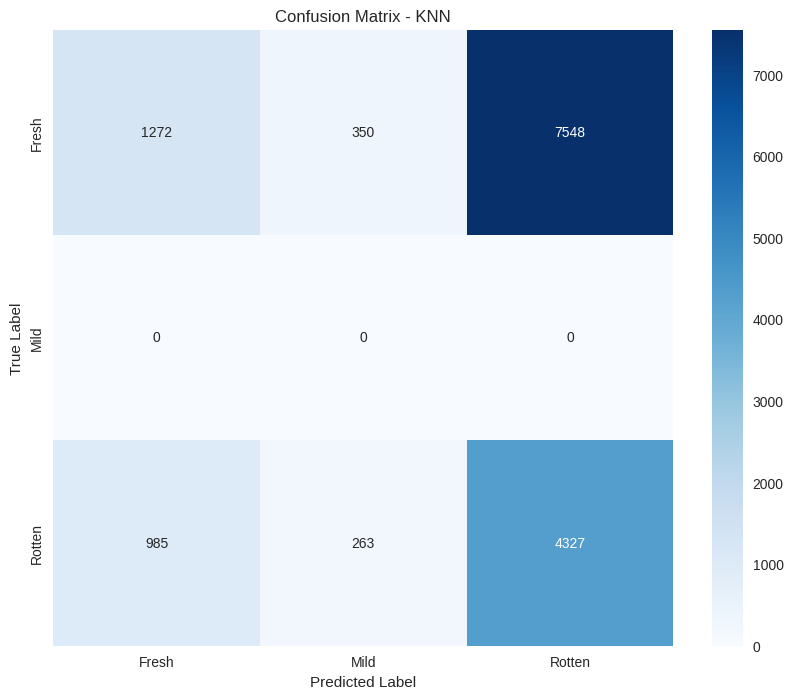


Evaluating KNN on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.213
Mild/Mixed: 0.150
Rotten/Bad: 0.637

Prediction distribution for mixed quality fruits:
Good/Fresh: 240 (22.3%)
Mild/Mixed: 158 (14.7%)
Rotten/Bad: 676 (62.9%)

Average prediction entropy: 0.099

Training SVM...
Evaluating SVM on clear quality data...

SVM Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.85      0.44      0.58      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.52      0.80      0.63      5575

    accuracy                           0.58     14745
   macro avg       0.46      0.41      0.40     14745
weighted avg       0.72      0.58      0.60     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


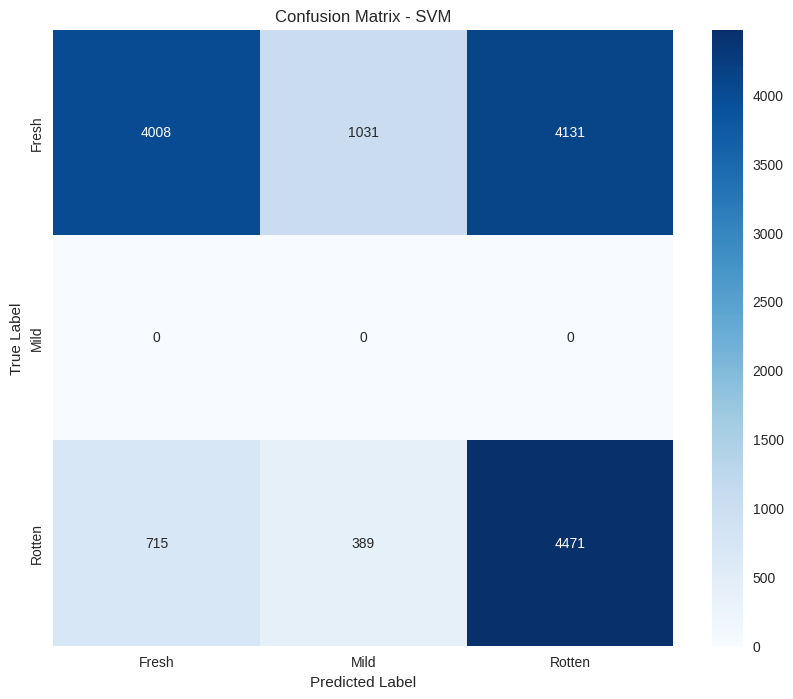


Evaluating SVM on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.655
Mild/Mixed: 0.067
Rotten/Bad: 0.278

Prediction distribution for mixed quality fruits:
Good/Fresh: 739 (68.8%)
Mild/Mixed: 32 (3.0%)
Rotten/Bad: 303 (28.2%)

Average prediction entropy: 0.319

Training Random Forest...
Evaluating Random Forest on clear quality data...

Random Forest Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.69      0.04      0.08      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.43      0.92      0.58      5575

    accuracy                           0.37     14745
   macro avg       0.37      0.32      0.22     14745
weighted avg       0.59      0.37      0.27     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


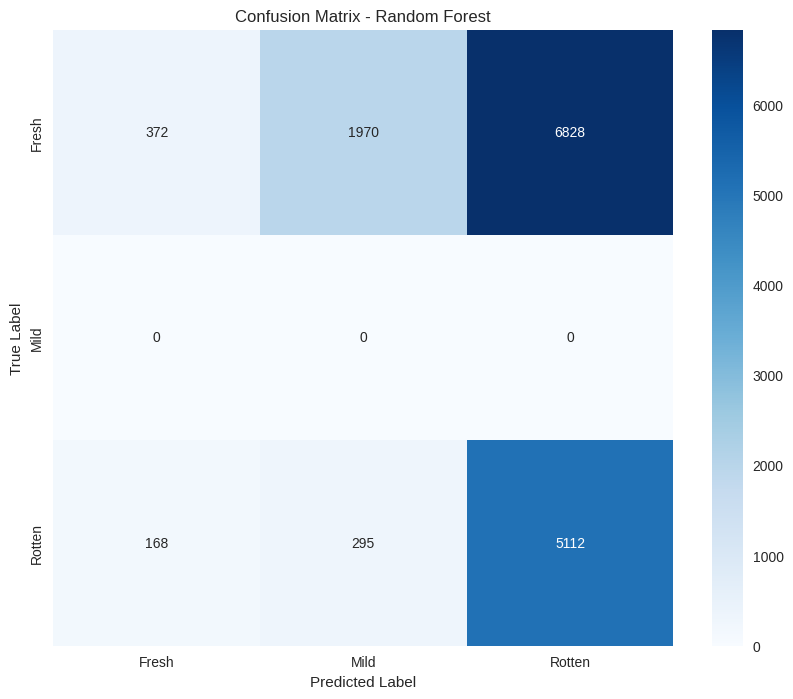


Evaluating Random Forest on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.289
Mild/Mixed: 0.347
Rotten/Bad: 0.364

Prediction distribution for mixed quality fruits:
Good/Fresh: 41 (3.8%)
Mild/Mixed: 569 (53.0%)
Rotten/Bad: 464 (43.2%)

Average prediction entropy: 1.518

Training Neural Network...
Evaluating Neural Network on clear quality data...

Neural Network Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.87      0.46      0.60      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.52      0.81      0.63      5575

    accuracy                           0.59     14745
   macro avg       0.46      0.42      0.41     14745
weighted avg       0.73      0.59      0.61     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


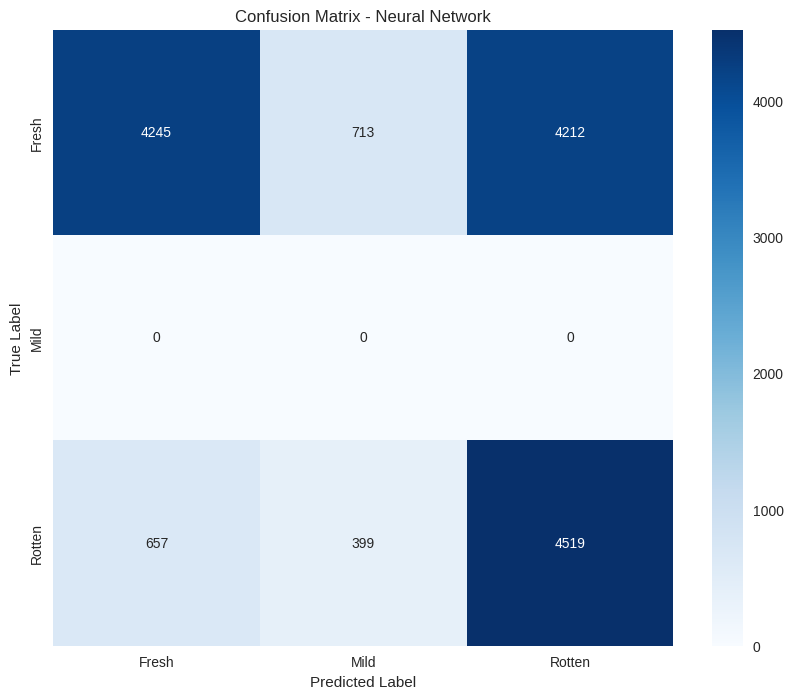


Evaluating Neural Network on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.295
Mild/Mixed: 0.273
Rotten/Bad: 0.432

Prediction distribution for mixed quality fruits:
Good/Fresh: 318 (29.6%)
Mild/Mixed: 291 (27.1%)
Rotten/Bad: 465 (43.3%)

Average prediction entropy: 0.116

Training Decision Tree...
Evaluating Decision Tree on clear quality data...

Decision Tree Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.74      0.49      0.59      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.56      0.60      0.58      5575

    accuracy                           0.53     14745
   macro avg       0.43      0.36      0.39     14745
weighted avg       0.67      0.53      0.59     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


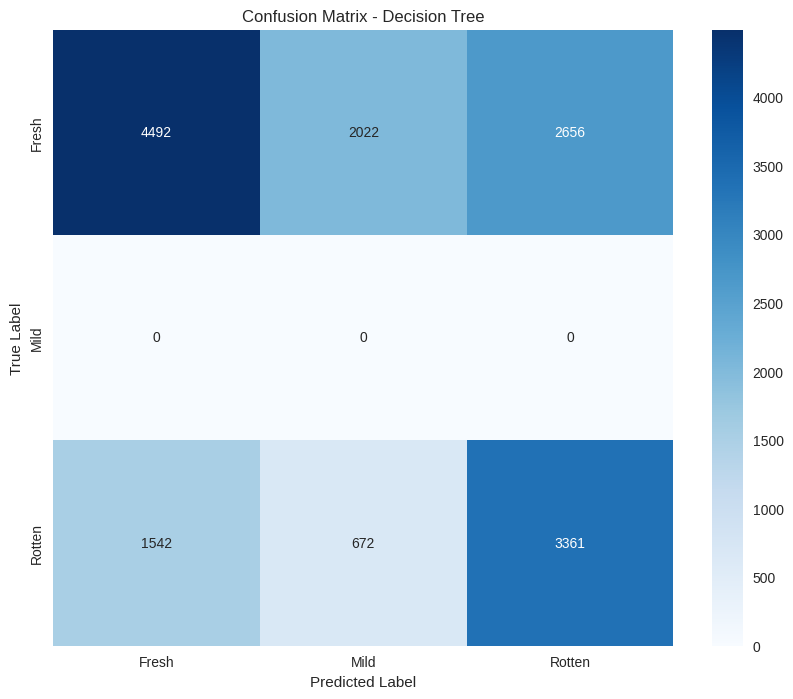


Evaluating Decision Tree on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.466
Mild/Mixed: 0.358
Rotten/Bad: 0.175

Prediction distribution for mixed quality fruits:
Good/Fresh: 501 (46.6%)
Mild/Mixed: 385 (35.8%)
Rotten/Bad: 188 (17.5%)

Average prediction entropy: -0.000

=== Scenario 2: Combined Dataset Evaluation ===

Training KNN on combined dataset...
Evaluating KNN...

KNN Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.99      0.97      0.98      2271
        Mild       0.99      1.00      0.99       273
      Rotten       0.96      0.99      0.97      1535

    accuracy                           0.98      4079
   macro avg       0.98      0.98      0.98      4079
weighted avg       0.98      0.98      0.98      4079



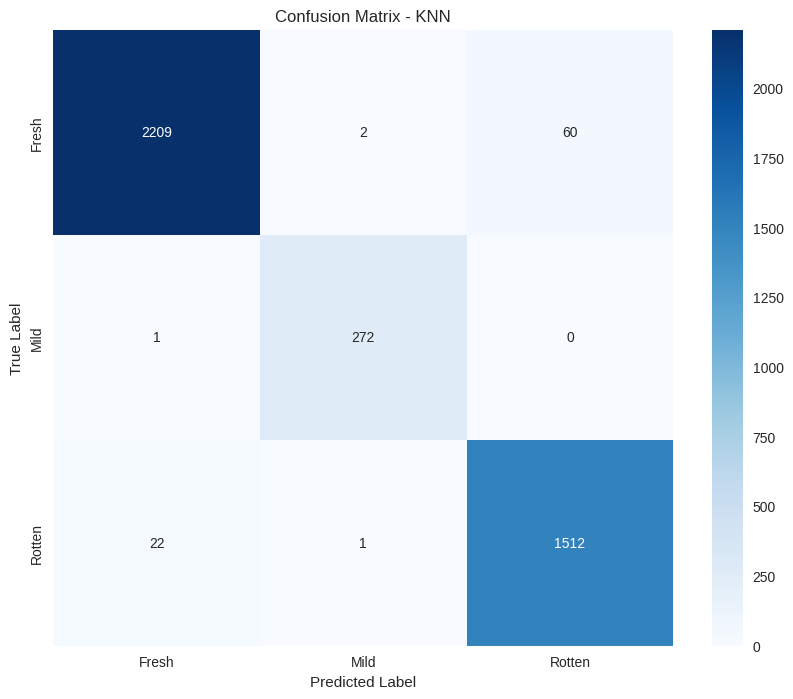


Evaluating KNN on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.754
Mild/Mixed: 0.000
Rotten/Bad: 0.246

Prediction distribution for mixed quality fruits:
Good/Fresh: 828 (77.1%)
Rotten/Bad: 246 (22.9%)

Average prediction entropy: 0.326

Training SVM on combined dataset...
Evaluating SVM...

SVM Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.96      0.96      0.96      2271
        Mild       0.93      0.80      0.86       273
      Rotten       0.96      0.97      0.97      1535

    accuracy                           0.96      4079
   macro avg       0.95      0.91      0.93      4079
weighted avg       0.96      0.96      0.96      4079



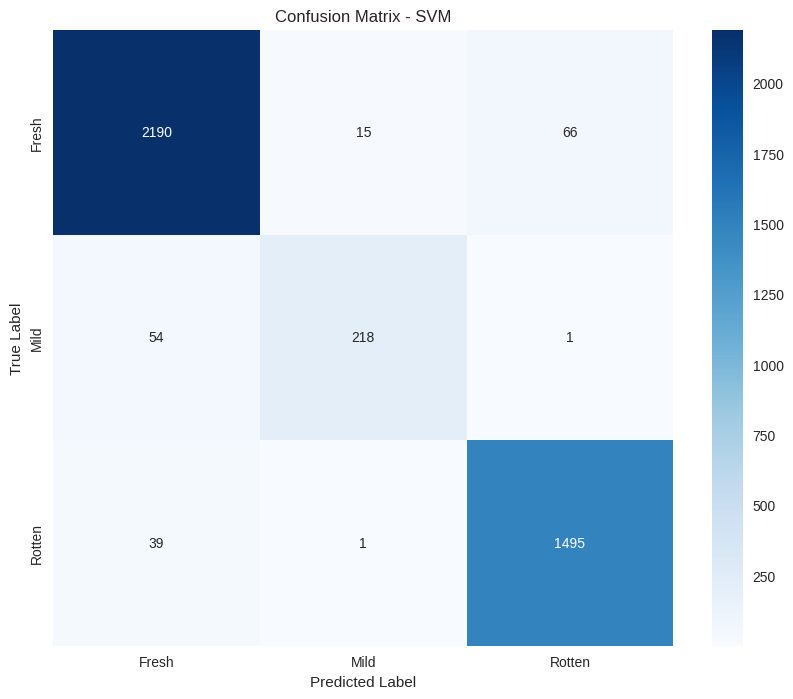


Evaluating SVM on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.845
Mild/Mixed: 0.002
Rotten/Bad: 0.153

Prediction distribution for mixed quality fruits:
Good/Fresh: 915 (85.2%)
Rotten/Bad: 159 (14.8%)

Average prediction entropy: 0.354

Training Random Forest on combined dataset...
Evaluating Random Forest...

Random Forest Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.99      0.98      0.99      2271
        Mild       1.00      0.99      1.00       273
      Rotten       0.98      0.99      0.98      1535

    accuracy                           0.99      4079
   macro avg       0.99      0.99      0.99      4079
weighted avg       0.99      0.99      0.99      4079



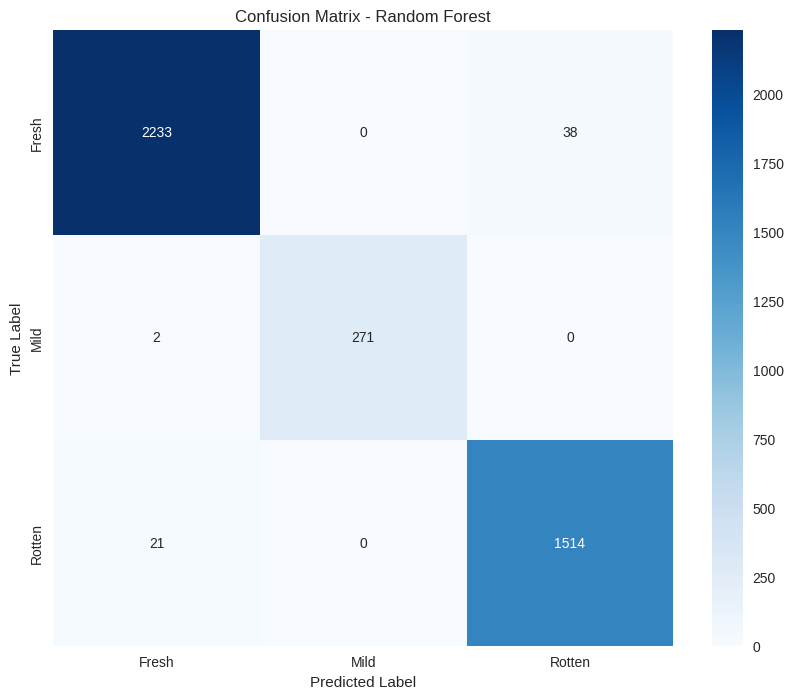


Evaluating Random Forest on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.759
Mild/Mixed: 0.002
Rotten/Bad: 0.239

Prediction distribution for mixed quality fruits:
Good/Fresh: 958 (89.2%)
Rotten/Bad: 116 (10.8%)

Average prediction entropy: 0.657

Training Neural Network on combined dataset...
Evaluating Neural Network...

Neural Network Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      0.98      0.99      2271
        Mild       0.99      1.00      0.99       273
      Rotten       0.97      0.99      0.98      1535

    accuracy                           0.99      4079
   macro avg       0.99      0.99      0.99      4079
weighted avg       0.99      0.99      0.99      4079



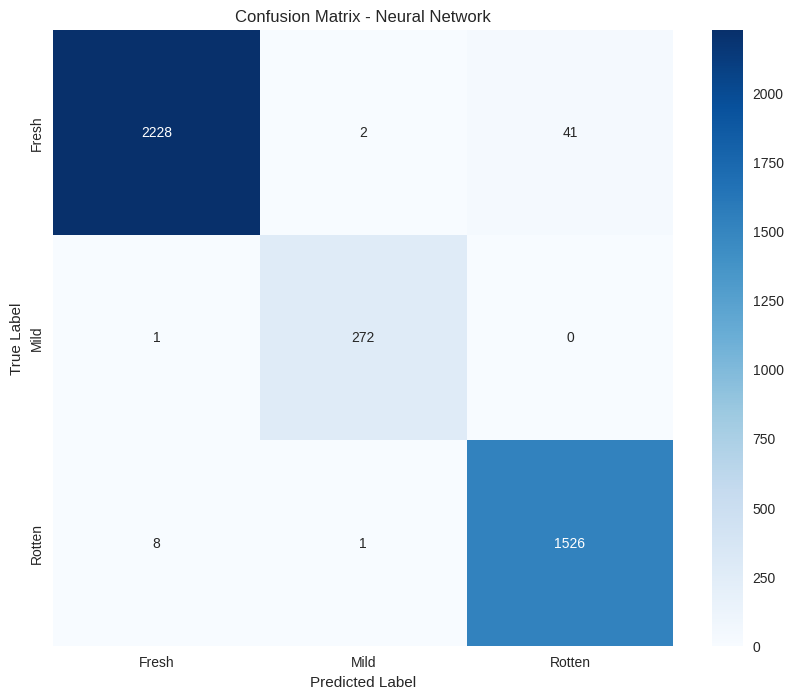


Evaluating Neural Network on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.740
Mild/Mixed: 0.000
Rotten/Bad: 0.260

Prediction distribution for mixed quality fruits:
Good/Fresh: 805 (75.0%)
Rotten/Bad: 269 (25.0%)

Average prediction entropy: 0.217

Training Decision Tree on combined dataset...
Evaluating Decision Tree...

Decision Tree Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.97      0.97      0.97      2271
        Mild       0.99      1.00      0.99       273
      Rotten       0.96      0.96      0.96      1535

    accuracy                           0.97      4079
   macro avg       0.98      0.98      0.98      4079
weighted avg       0.97      0.97      0.97      4079



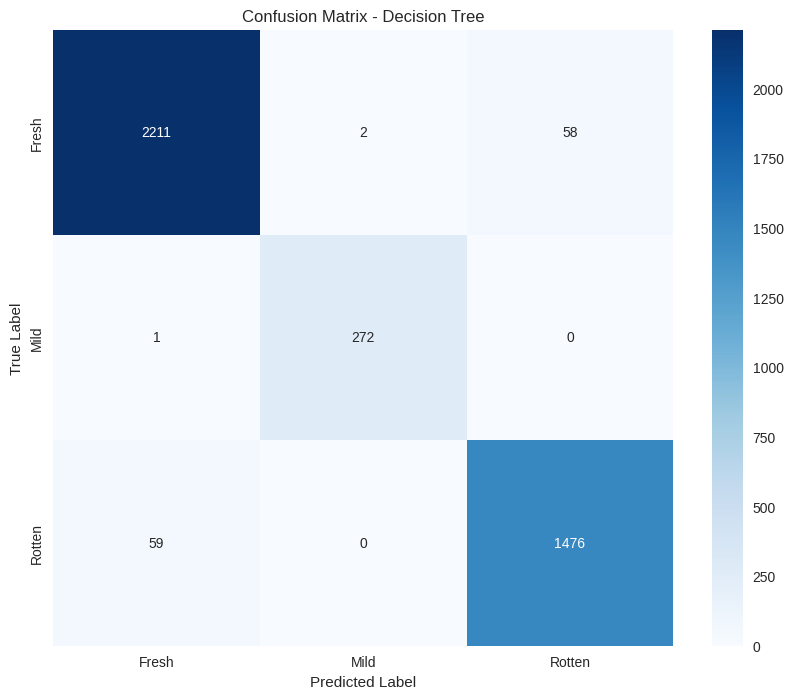


Evaluating Decision Tree on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.805
Mild/Mixed: 0.000
Rotten/Bad: 0.195

Prediction distribution for mixed quality fruits:
Good/Fresh: 865 (80.5%)
Rotten/Bad: 209 (19.5%)

Average prediction entropy: -0.000


In [17]:
class CrossDatasetEvaluator:
    def __init__(self):
        self.loader = FruitQualityDataLoader()
        self.extractor = FruitFeatureExtractor()
        self.evaluator = ModelEvaluator()
        self.classifiers = {
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'SVM': SVC(kernel='rbf', probability=True),
            'Random Forest': RandomForestClassifier(n_estimators=100),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50)),
            'Decision Tree': DecisionTreeClassifier()
        }
        
    def load_and_prepare_datasets(self, zenodo_path, kaggle_path):
        """Load and prepare both datasets separately"""
        print("Loading Zenodo dataset...")
        zenodo_paths, zenodo_labels = self.loader.load_zenodo_dataset(zenodo_path, subset="FruQ-DB")
        
        print("\nLoading Kaggle dataset...")
        kaggle_paths, kaggle_labels = self.loader.load_kaggle_dataset(kaggle_path)
        
        # Create separate test sets for clear quality and mixed quality
        kaggle_clear_mask = kaggle_labels != 1  # Exclude mixed quality
        kaggle_mixed_mask = kaggle_labels == 1  # Only mixed quality
        
        kaggle_clear_paths = [p for p, m in zip(kaggle_paths, kaggle_clear_mask) if m]
        kaggle_clear_labels = kaggle_labels[kaggle_clear_mask]
        
        kaggle_mixed_paths = [p for p, m in zip(kaggle_paths, kaggle_mixed_mask) if m]
        kaggle_mixed_labels = kaggle_labels[kaggle_mixed_mask]
        
        # Extract features
        print("\nExtracting features...")
        print("Zenodo dataset...")
        X_zenodo = self.extractor.prepare_dataset(zenodo_paths, fit_scaler=True)
        
        print("Kaggle clear quality dataset...")
        X_kaggle_clear = self.extractor.prepare_dataset(kaggle_clear_paths, fit_scaler=False)
        
        print("Kaggle mixed quality dataset...")
        X_kaggle_mixed = self.extractor.prepare_dataset(kaggle_mixed_paths, fit_scaler=False)
        
        return {
            'zenodo': (X_zenodo, zenodo_labels),
            'kaggle_clear': (X_kaggle_clear, kaggle_clear_labels),
            'kaggle_mixed': (X_kaggle_mixed, kaggle_mixed_labels)
        }
    
    def evaluate_mixed_quality(self, model, X_mixed, mixed_labels):
        """Special evaluation for mixed quality fruits"""
        # Get probability predictions for each class
        probabilities = model.predict_proba(X_mixed)
        
        # Calculate average probability distribution
        avg_probs = np.mean(probabilities, axis=0)
        print("\nAverage probability distribution for mixed quality fruits:")
        for label, prob in zip(self.loader.quality_labels, avg_probs):
            print(f"{label}: {prob:.3f}")
        
        # Analyze prediction distribution
        predictions = model.predict(X_mixed)
        unique, counts = np.unique(predictions, return_counts=True)
        print("\nPrediction distribution for mixed quality fruits:")
        for label, count in zip(unique, counts):
            percentage = (count / len(predictions)) * 100
            print(f"{self.loader.quality_labels[label]}: {count} ({percentage:.1f}%)")
            
        # Calculate uncertainty metrics
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10), axis=1)
        print(f"\nAverage prediction entropy: {np.mean(entropy):.3f}")
    
    def run_evaluation_scenarios(self, zenodo_path, kaggle_path):
        """Run all evaluation scenarios"""
        # Load and prepare all datasets
        datasets = self.load_and_prepare_datasets(zenodo_path, kaggle_path)
        
        # Scenario 1: Train on Zenodo, test on Kaggle clear quality
        print("\n=== Scenario 1: Train on Zenodo, Test on Kaggle (Clear Quality) ===")
        X_train, y_train = datasets['zenodo']
        X_test, y_test = datasets['kaggle_clear']
        
        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")
            clf.fit(X_train, y_train)
            
            print(f"Evaluating {name} on clear quality data...")
            predictions = clf.predict(X_test)
            self.evaluator.evaluate_model(y_test, predictions, name)
            
            print(f"\nEvaluating {name} on mixed quality data...")
            X_mixed, y_mixed = datasets['kaggle_mixed']
            self.evaluate_mixed_quality(clf, X_mixed, y_mixed)
        
        # Scenario 2: Combined dataset evaluation
        print("\n=== Scenario 2: Combined Dataset Evaluation ===")
        # Combine Zenodo and Kaggle clear quality data
        X_combined = np.vstack([datasets['zenodo'][0], datasets['kaggle_clear'][0]])
        y_combined = np.concatenate([datasets['zenodo'][1], datasets['kaggle_clear'][1]])
        
        # Split combined dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
        )
        
        for name, clf in self.classifiers.items():
            print(f"\nTraining {name} on combined dataset...")
            clf.fit(X_train, y_train)
            
            print(f"Evaluating {name}...")
            predictions = clf.predict(X_test)
            self.evaluator.evaluate_model(y_test, predictions, name)
            
            print(f"\nEvaluating {name} on mixed quality data...")
            X_mixed, y_mixed = datasets['kaggle_mixed']
            self.evaluate_mixed_quality(clf, X_mixed, y_mixed)



In [ ]:
evaluator = CrossDatasetEvaluator()
evaluator.run_evaluation_scenarios(
    zenodo_path='fruit_datasets/zenodo_data',
    kaggle_path='fruit_datasets/kaggle_data'
)